<a href="https://colab.research.google.com/github/BARKHAC/HandwrittenEqn-LatexConverter/blob/main/LatexEqnGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers

In [ ]:
!pip install -q datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls -R /content/drive/MyDrive

/content/drive/MyDrive:
 001-equation000.inkml.png    4_em_22.inkml.png   trocr_checkpoints
 001-equation0010.inkml.png  'Colab Notebooks'	 'Untitled document (1).gdoc'
 121_em_328.inkml.png	      LatexModel	 'Untitled document.gdoc'

'/content/drive/MyDrive/Colab Notebooks':
'Alt-Text Generator.ipynb'		 Img_Experiments_Transformers.ipynb   spacyPractical.ipynb
 bert-contentSegment-questionGen.ipynb	 LatexEqnGenerator.ipynb
 BertSquad.ipynb			 RecipeApp.ipynb

/content/drive/MyDrive/LatexModel:
config.json		model.safetensors	  special_tokens_map.json  tokenizer.json
generation_config.json	preprocessor_config.json  tokenizer_config.json

/content/drive/MyDrive/trocr_checkpoints:
checkpoint-5310

/content/drive/MyDrive/trocr_checkpoints/checkpoint-5310:
config.json		optimizer.pt   special_tokens_map.json	trainer_state.json
generation_config.json	rng_state.pth  tokenizer_config.json	training_args.bin
model.safetensors	scheduler.pt   tokenizer.json


In [ ]:
!unzip /content/drive/MyDrive/5k_dataset_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: 5k_dataset_new/labels_5k_new/001-equation0011.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation0012.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation0013.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation003.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation005.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation006.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation007.txt  
  inflating: 5k_dataset_new/labels_5k_new/001-equation008.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation001.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation002.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation005.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation007.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation008.txt  
  inflating: 5k_dataset_new/labels_5k_new/002-equation009.txt  
  inflating: 5k_dataset_new/labels_5k_new/101_carl

In [ ]:
!pip install evaluate
from evaluate import load as load_metric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00


In [ ]:
!pip install datasets

In [ ]:
def compute_metrics(pred):
    # pred is an object with 'predictions' and 'label_ids'
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # Decode predictions using our custom tokenizer
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # Replace -100 in labels with the pad token id
    label_ids[label_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"cer": cer}


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTFeatureExtractor, PreTrainedTokenizerFast

class HandwrittenEquationDataset(Dataset):
    def __init__(self, img_dir, label_dir, tokenizer_path, processor_path, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform or transforms.ToTensor()  # Default to ToTensor()
        # Load ViTFeatureExtractor for image processing
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(processor_path)

        # Load tokenizer
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        # Get all image filenames ending with .png
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Process the image using the processor (resizing, normalizing, etc.)
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)

        # Get corresponding label filename
        base_name = img_filename.replace('.inkml.png', '')
        label_filename = base_name + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)

        # Load label
        with open(label_path, "r", encoding="utf-8") as f:
            label_text = f.read().strip()
            # Tokenize label
        tokenized_label = self.tokenizer(label_text, return_tensors="pt")

        return {"pixel_values": pixel_values, "labels": tokenized_label["input_ids"].squeeze(0)}


def collate_fn(batch, tokenizer):
    # Extract images and labels from the list of dictionaries
    images = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Convert images to tensor
    images = torch.stack(images)

    # Print raw tokenized labels before padding
    print("Raw tokenized labels:", labels)

    # Find the longest sequence in this batch
    max_len = max(label.shape[0] for label in labels)
    print(f"Max label length in batch: {max_len}")

    # Pad labels dynamically
    padded_labels = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=-100
    )

    return images, padded_labels

# Example usage
tokenizer_path = ""
dataset = HandwrittenEquationDataset(
    img_dir="/content/5k_dataset_new/images_5k_new",
    label_dir="/content/5k_dataset_new/labels_5k_new",
    tokenizer_path="/content/dataset_5k/latex_tokenizer_sentencepiece",
    processor_path="microsoft/trocr-base-stage1"  # Uses only the ViT feature extractor
)


# Create DataLoader with custom collate function
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda b: collate_fn(b, dataset.tokenizer))

# Fetch a batch and verify
images, tokenized_labels = next(iter(dataloader))
print(f"Batch images shape: {images.shape}")  # Should be (batch_size, 1, H, W)
print(f"Batch tokenized labels shape: {tokenized_labels.shape}")
print(f"Sample tokenized label: {tokenized_labels[0]}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Raw tokenized labels: [tensor([71]), tensor([308,  24, 333,  24, 347,  79,  23,  23]), tensor([  36, 4258]), tensor([  26,   32,  174, 3703,   26,   32,  174,  981,   27,   26,   32,  306,
        1046])]
Max label length in batch: 13
Batch images shape: torch.Size([4, 3, 384, 384])
Batch tokenized labels shape: torch.Size([4, 13])
Sample tokenized label: tensor([  71, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100])


2nd March 2025: New DataLoader(basically same but with loading tokenizer from saved model at LatexModel)

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import ViTFeatureExtractor, PreTrainedTokenizerFast

class HandwrittenEquationDataset(Dataset):
    def __init__(self, img_dir, label_dir, tokenizer_path, processor_path, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform or transforms.ToTensor()  # Default to ToTensor()
        # Load ViTFeatureExtractor for image processing
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(processor_path)

        # Load tokenizer from the pretrained model folder (LatexModel)
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        # Get all image filenames ending with .png
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Process the image using the feature extractor (resizing, normalizing, etc.)
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)

        # Get corresponding label filename
        base_name = img_filename.replace('.inkml.png', '')
        label_filename = base_name + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)

        # Load label and tokenize
        with open(label_path, "r", encoding="utf-8") as f:
            label_text = f.read().strip()
        tokenized_label = self.tokenizer(label_text, return_tensors="pt")

        return {"pixel_values": pixel_values, "labels": tokenized_label["input_ids"].squeeze(0)}


def collate_fn(batch, tokenizer):
    # Extract images and labels from the list of dictionaries
    images = [item["pixel_values"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Convert images to tensor
    images = torch.stack(images)

    # Print raw tokenized labels before padding
    print("Raw tokenized labels:", labels)

    # Find the longest sequence in this batch
    max_len = max(label.shape[0] for label in labels)
    print(f"Max label length in batch: {max_len}")

    # Pad labels dynamically; using -100 as the padding value for labels
    padded_labels = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=-100
    )

    return images, padded_labels


# Example usage:
# Set the tokenizer_path to point to your saved model (LatexModel) folder.
tokenizer_path = "/content/drive/MyDrive/LatexModel"  # <-- Updated to your model folder
processor_path = "microsoft/trocr-base-stage1"         # Using the ViT feature extractor from TroCR

dataset = HandwrittenEquationDataset(
    img_dir="/content/5k_dataset_new/images_5k_new",
    label_dir="/content/5k_dataset_new/labels_5k_new",
    tokenizer_path=tokenizer_path,
    processor_path=processor_path
)

# Create DataLoader with the custom collate function
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, dataset.tokenizer)
)

# Fetch a batch and verify
images, tokenized_labels = next(iter(dataloader))
print(f"Batch images shape: {images.shape}")          # Should be (batch_size, C, H, W)
print(f"Batch tokenized labels shape: {tokenized_labels.shape}")
print(f"Sample tokenized label: {tokenized_labels[0]}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Raw tokenized labels: [tensor([738,  91, 918]), tensor([ 57,  56,  44,  52,  35,  41,  84,  24,  94,  34,  39,  33,  84, 375,
         41,  39]), tensor([3831,   27,   29,   25,   49,   27,   29]), tensor([ 37,  24,  30,  25,  37,  24,  29,  25,  37,  24,  38,  25,  37, 249])]
Max label length in batch: 16
Batch images shape: torch.Size([4, 3, 384, 384])
Batch tokenized labels shape: torch.Size([4, 16])
Sample tokenized label: tensor([ 738,   91,  918, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100])


/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


2nd March 2025: New Training Snippet (basically same we are just loading the model from LatexModel)

In [ ]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from transformers import (
    VisionEncoderDecoderModel,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    PreTrainedTokenizerFast,
    ViTFeatureExtractor
)
from evaluate import load as load_metric

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define checkpoint directory
CHECKPOINT_DIR = "/content/drive/MyDrive/trocr_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Use the saved model from LatexModel folder (which also contains the tokenizer and preprocessor config)
MODEL_PATH = "/content/drive/MyDrive/LatexModel"  # Path to your saved model folder
TOKENIZER_PATH = MODEL_PATH  # Use the same folder for the tokenizer
PROCESSOR_PATH = MODEL_PATH  # Use the preprocessor configuration from the LatexModel folder

# Load tokenizer from LatexModel folder
tokenizer = PreTrainedTokenizerFast.from_pretrained(TOKENIZER_PATH)
# (Optional) Add pad token if needed
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load the model from LatexModel folder
model = VisionEncoderDecoderModel.from_pretrained(MODEL_PATH)
model.config.pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 1
model.config.decoder.pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 1
if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = 2

# Patch the encoder's forward function to remove an unexpected keyword argument.
original_encoder_forward = model.encoder.forward
def patched_encoder_forward(*args, **kwargs):
    kwargs.pop("num_items_in_batch", None)
    return original_encoder_forward(*args, **kwargs)
model.encoder.forward = patched_encoder_forward

# Define the dataset class inline
class HandwrittenEquationDataset(Dataset):
    def __init__(self, img_dir, label_dir, tokenizer_path, processor_path, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform or transforms.ToTensor()  # Default to ToTensor()
        # Load ViTFeatureExtractor for image processing using the preprocessor config in LatexModel folder
        self.feature_extractor = ViTFeatureExtractor.from_pretrained(processor_path)

        # Load tokenizer from the pretrained model folder (LatexModel)
        self.tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
        self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

        # Get all image filenames ending with .png
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        # Process the image using the feature extractor (resizing, normalizing, etc.)
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)

        # Get corresponding label filename
        base_name = img_filename.replace('.inkml.png', '')
        label_filename = base_name + '.txt'
        label_path = os.path.join(self.label_dir, label_filename)

        # Load label and tokenize
        with open(label_path, "r", encoding="utf-8") as f:
            label_text = f.read().strip()
        tokenized_label = self.tokenizer(label_text, return_tensors="pt")

        return {"pixel_values": pixel_values, "labels": tokenized_label["input_ids"].squeeze(0)}

# Define a custom collate function
def custom_data_collator(features):
    # Stack pixel_values (they are already tensors)
    pixel_values = torch.stack([f["pixel_values"] for f in features])
    # Pad labels dynamically using pad_sequence, using -100 as the pad value for labels
    labels = [f["labels"] for f in features]
    padded_labels = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=-100
    )
    return {"pixel_values": pixel_values, "labels": padded_labels}

# (Optional) A wrapper that removes extra keys if needed
def data_collator_wrapper(features):
    batch = custom_data_collator(features)
    batch.pop("num_items_in_batch", None)
    return batch

# (Optional) A simple compute_metrics function
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    # If pred_ids is a tuple, select the first element
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]
    # Replace -100 with the pad token id
    pred_ids[pred_ids == -100] = tokenizer.pad_token_id
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    # Calculate simple exact match accuracy
    exact_match = sum([1 if p.strip() == l.strip() else 0 for p, l in zip(pred_str, label_str)]) / len(pred_str)
    return {"exact_match": exact_match}

# Create the dataset using the new images and labels directories.
dataset = HandwrittenEquationDataset(
    img_dir="/content/5k_dataset_new/images_5k_new",
    label_dir="/content/5k_dataset_new/labels_5k_new",
    tokenizer_path=TOKENIZER_PATH,
    processor_path=PROCESSOR_PATH
)

# Split dataset into train and eval sets (e.g., 85% train, 15% eval)
train_size = int(0.85 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])
print(f"Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")

# Custom Trainer that filters out extra keys if needed.
class MySeq2SeqTrainer(Seq2SeqTrainer):
    def _prepare_inputs_for_model(self, inputs):
        allowed_keys = {"pixel_values", "labels"}
        filtered_inputs = {k: v for k, v in inputs.items() if k in allowed_keys}
        return super()._prepare_inputs_for_model(filtered_inputs)

# Training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir=CHECKPOINT_DIR,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    fp16=True,
    num_train_epochs=5,
    logging_steps=500,
    evaluation_strategy="no",  # Disable eval during training to reduce VRAM usage
    save_steps=1500,
    save_strategy="steps",
    save_total_limit=1,
    load_best_model_at_end=False,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none",
    gradient_checkpointing=True
)

# Initialize the Trainer with the custom data collator and trainer class.
trainer = MySeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_data_collator,  # You can also use data_collator_wrapper if preferred.
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Check for an existing checkpoint (if any)
checkpoint_paths = glob.glob(f"{CHECKPOINT_DIR}/checkpoint-*")
checkpoint_path = max(checkpoint_paths, key=os.path.getctime) if checkpoint_paths else None
if checkpoint_path:
    print(f"Resuming from checkpoint: {checkpoint_path}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Start training (resuming from checkpoint if available)
trainer.train(resume_from_checkpoint=checkpoint_path if checkpoint_path else None)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Train size: 4250, Eval size: 750


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-17-481005521a16>:164: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MySeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = MySeq2SeqTrainer(


No checkpoint found. Starting training from scratch.


Step,Training Loss
500,17.905600
1000,17.447700
1500,13.765900
2000,13.335600
2500,11.655600
3000,10.592000
3500,9.743100
4000,9.087600
4500,8.443900
5000,8.005100


TrainOutput(global_step=5310, training_loss=11.748375844147246, metrics={'train_runtime': 4527.7519, 'train_samples_per_second': 4.693, 'train_steps_per_second': 1.173, 'total_flos': 1.8788100208431464e+19, 'train_loss': 11.748375844147246, 'epoch': 4.995764705882353})

In [ ]:
import os
import glob
import torch
from torch.utils.data import DataLoader, random_split
from transformers import VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import PreTrainedTokenizerFast
from evaluate import load as load_metric

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define checkpoint directory
CHECKPOINT_DIR = "/content/drive/MyDrive/trocr_checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Load tokenizer
TOKENIZER_PATH = "/content/dataset_5k/latex_tokenizer_sentencepiece"
tokenizer = PreTrainedTokenizerFast.from_pretrained(TOKENIZER_PATH)

# (Optional: if the tokenizer already has a pad token, you don't need to add one)
# tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load TrOCR model
MODEL_NAME = "microsoft/trocr-base-stage1"
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)



model.config.pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 1
model.config.decoder.pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 1


if model.config.decoder_start_token_id is None:
    model.config.decoder_start_token_id = 2

original_encoder_forward = model.encoder.forward
def patched_encoder_forward(*args, **kwargs):
    kwargs.pop("num_items_in_batch", None)
    return original_encoder_forward(*args, **kwargs)
model.encoder.forward = patched_encoder_forward

# Assume HandwrittenEquationDataset is defined as before and returns a dictionary:
# {"pixel_values": image, "labels": tokenized_label}
dataset = HandwrittenEquationDataset(
    img_dir="/content/dataset_5k/images_5k",
    label_dir="/content/dataset_5k/labels_5k",
    tokenizer_path=TOKENIZER_PATH,
    processor_path="microsoft/trocr-base-stage1"  # Uses only the ViT feature extractor
)

# Split dataset into train and eval sets
train_size = int(0.85 * len(dataset))  # 90% train, 10% eval
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

print(f"Train size: {len(train_dataset)}, Eval size: {len(eval_dataset)}")

# Define a custom data collator that works with our dictionary format and removes extra keys
def custom_data_collator(features):
    # Stack pixel_values (they are already tensors)
    pixel_values = torch.stack([f["pixel_values"] for f in features])

    # Pad labels dynamically using pad_sequence
    labels = [f["labels"] for f in features]
    padded_labels = torch.nn.utils.rnn.pad_sequence(
        labels, batch_first=True, padding_value=-100
    )

    batch = {"pixel_values": pixel_values, "labels": padded_labels}
    return batch

def data_collator_wrapper(features):
    batch = custom_data_collator(features)
    # Remove any keys that might have been added by the Trainer; for example:
    batch.pop("num_items_in_batch", None)
    return batch

# Training Arguments


class MySeq2SeqTrainer(Seq2SeqTrainer):
    def _prepare_inputs_for_model(self, inputs):
        # Only keep keys that the model's forward function accepts.
        allowed_keys = {"pixel_values", "labels"}
        filtered_inputs = {k: v for k, v in inputs.items() if k in allowed_keys}
        return super()._prepare_inputs_for_model(filtered_inputs)


training_args = Seq2SeqTrainingArguments(
    output_dir=CHECKPOINT_DIR,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,  # Keep eval batch size low
    gradient_accumulation_steps=4,  # Helps compensate for small batch size
    fp16=True,  # Saves VRAM using mixed precision
    num_train_epochs=5,  # Avoid excessive memory usage over long runs
    logging_steps=500,
    evaluation_strategy="no",  # **Best way to prevent crashes during eval**
    save_steps=1500,  # **Less frequent saves to reduce memory spikes**
    save_strategy="steps",
    save_total_limit=1,  # Keep only **1 checkpoint** to reduce storage
    save_on_each_node=False,
    load_best_model_at_end=False,  # **Disable to avoid extra VRAM use**
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none",
    gradient_checkpointing=True,  # Helps save VRAM at the cost of slower training
)

# Trainer
# Trainer using the custom collator and custom trainer class
trainer = MySeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=custom_data_collator,  # Our previously defined collator
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


# Check for an existing checkpoint (if any)
checkpoint_path = max(glob.glob(f"{CHECKPOINT_DIR}/checkpoint-*"), default=None)
if checkpoint_path:
    print(f"Resuming from checkpoint: {checkpoint_path}")
else:
    print("No checkpoint found. Starting training from scratch.")

# Train with checkpointing
trainer.train(resume_from_checkpoint=checkpoint_path if checkpoint_path else None)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


model.safetensors:  27%|##6       | 409M/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-23f5c5d66950>:112: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MySeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = MySeq2SeqTrainer(


Train size: 4250, Eval size: 750
No checkpoint found. Starting training from scratch.


Step,Training Loss
500,23.723200
1000,22.391700
1500,20.166000
2000,19.505100
2500,17.142800
3000,16.195700
3500,14.208600
4000,13.069100
4500,12.056600
5000,10.894900


TrainOutput(global_step=5310, training_loss=16.560678922434086, metrics={'train_runtime': 4391.2187, 'train_samples_per_second': 4.839, 'train_steps_per_second': 1.209, 'total_flos': 1.8788100208431464e+19, 'train_loss': 16.560678922434086, 'epoch': 4.995764705882353})

In [ ]:
# After training is complete:
from transformers import ViTFeatureExtractor

# 1. Save your trained model and tokenizer
model_save_path = "/content/drive/MyDrive/LatexNewModel"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

# 2. Save the feature extractor to the same directory
feature_extractor = ViTFeatureExtractor.from_pretrained("microsoft/trocr-base-stage1")
feature_extractor.save_pretrained(model_save_path)

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


['/content/drive/MyDrive/LatexNewModel/preprocessor_config.json']

In [ ]:
# Loading the complete model
from transformers import VisionEncoderDecoderModel, PreTrainedTokenizerFast, ViTFeatureExtractor

model_save_path = "/content/drive/MyDrive/LatexNewModel"
model = VisionEncoderDecoderModel.from_pretrained(model_save_path)
tokenizer = PreTrainedTokenizerFast.from_pretrained(model_save_path)
processor = ViTFeatureExtractor.from_pretrained(model_save_path)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [ ]:
# import torch
# from PIL import Image
# import matplotlib.pyplot as plt

# class HandwrittenLatexOCR:
#     def __init__(self, model, feature_extractor, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
#         self.model = model.to(device)
#         self.feature_extractor = feature_extractor
#         self.tokenizer = tokenizer
#         self.device = device
#         self.model.eval()

#     def preprocess_image(self, image):
#         if isinstance(image, str):
#             image = Image.open(image).convert('RGB')
#         elif not isinstance(image, Image.Image):
#             raise ValueError("Input must be a PIL Image or path to image")

#         pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
#         return pixel_values.to(self.device), image

#     @torch.no_grad()
#     def __call__(self, image, max_length=15):  # Significantly reduced max_length
#         pixel_values, original_image = self.preprocess_image(image)

#         # More conservative generation parameters
#         outputs = self.model.generate(
#             pixel_values,
#             max_length=max_length,
#             num_beams=5,  # Increased slightly for better search
#             early_stopping=True,
#             pad_token_id=self.tokenizer.pad_token_id,
#             eos_token_id=self.tokenizer.eos_token_id,
#             bos_token_id=self.model.config.decoder_start_token_id,
#             use_cache=True,
#             length_penalty=1.0,  # Neutral length penalty
#             no_repeat_ngram_size=1,  # Prevent immediate repetition
#             repetition_penalty=3.0,  # Strong repetition penalty
#             temperature=0.7,  # More conservative sampling
#             top_k=20,  # More restricted top-k
#             do_sample=False  # Disable sampling for more deterministic output
#         )

#         predicted_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

#         # Clean up common issues in the output
#         predicted_text = self._clean_prediction(predicted_text)

#         plt.figure(figsize=(8, 6))
#         plt.imshow(original_image)
#         plt.axis('off')
#         plt.show()
#         print(f"Predicted LaTeX: {predicted_text}")

#         return predicted_text

#     def _clean_prediction(self, text):
#         """Clean up common issues in predictions"""
#         # Remove multiple spaces
#         text = ' '.join(text.split())

#         # Remove repeated symbols
#         prev_char = None
#         cleaned = []
#         for char in text.split(','):
#             if char != prev_char:
#                 cleaned.append(char)
#                 prev_char = char
#         text = ','.join(cleaned)

#         # Remove unnecessary spaces around operators
#         text = text.replace(' , ', ', ')
#         text = text.replace(' \\', '\\')

#         return text.strip()

#     def batch_inference(self, images, batch_size=8, max_length=15):
#         predictions = []
#         for i in range(0, len(images), batch_size):
#             batch = images[i:i + batch_size]

#             if isinstance(batch[0], str):
#                 batch = [Image.open(img).convert('RGB') for img in batch]

#             pixel_values = self.feature_extractor(batch, return_tensors="pt").pixel_values
#             pixel_values = pixel_values.to(self.device)

#             with torch.no_grad():
#                 outputs = self.model.generate(
#                     pixel_values,
#                     max_length=max_length,
#                     num_beams=5,
#                     early_stopping=True,
#                     pad_token_id=self.tokenizer.pad_token_id,
#                     eos_token_id=self.tokenizer.eos_token_id,
#                     bos_token_id=self.model.config.decoder_start_token_id,
#                     use_cache=True,
#                     length_penalty=1.0,
#                     no_repeat_ngram_size=1,
#                     repetition_penalty=3.0,
#                     temperature=0.7,
#                     top_k=20,
#                     do_sample=False
#                 )

#             batch_predictions = [
#                 self._clean_prediction(self.tokenizer.decode(output, skip_special_tokens=True))
#                 for output in outputs
#             ]

#             for img, pred in zip(batch, batch_predictions):
#                 plt.figure(figsize=(8, 6))
#                 plt.imshow(img)
#                 plt.axis('off')
#                 plt.show()
#                 print(f"Predicted LaTeX: {pred}")
#                 print("-" * 50)

#             predictions.extend(batch_predictions)

#         return predictions

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

class HandwrittenLatexOCR:
    def __init__(self, model, feature_extractor, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.feature_extractor = feature_extractor
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()

    def preprocess_image(self, image):
        if isinstance(image, str):
            image = Image.open(image).convert('RGB')
        elif not isinstance(image, Image.Image):
            raise ValueError("Input must be a PIL Image or path to image")
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        return pixel_values.to(self.device), image

    @torch.no_grad()
    def __call__(self, image, max_length=12):  # Increased max_length
        pixel_values, original_image = self.preprocess_image(image)

        # Modified generation parameters
        outputs = self.model.generate(
            pixel_values,
            max_length=max_length,
            num_beams=8,              # Increase beams for better search
            early_stopping=True,
            pad_token_id=self.tokenizer.pad_token_id,
            eos_token_id=self.tokenizer.eos_token_id,
            bos_token_id=self.model.config.decoder_start_token_id,
            use_cache=True,
            length_penalty=1.0,
            no_repeat_ngram_size=2,   # Allow 2-gram repetition prevention
            repetition_penalty=1.2,   # Lower repetition penalty
            temperature=1.0,          # More diversity in sampling
            top_k=50,                 # Increase top_k for a wider candidate set
            top_p=0.95,               # Enable nucleus sampling
            do_sample=False          # Enable sampling for more natural outputs
        )

        predicted_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Clean up prediction using a simpler cleaning function
        predicted_text = self._clean_prediction(predicted_text)

        plt.figure(figsize=(8, 6))
        plt.imshow(original_image)
        plt.axis('off')
        plt.show()
        print(f"Predicted LaTeX: {predicted_text}")

        return predicted_text

    def _clean_prediction(self, text):
        """Simplify post-processing: remove extra spaces and accidental spacing before punctuation."""
        # Remove multiple spaces
        text = ' '.join(text.split())
        # Remove spaces before common punctuation (e.g., commas, periods, backslashes)
        for punct in [',', '.', '\\', '{', '}', '(', ')']:
            text = text.replace(" " + punct, punct)
        return text.strip()

    def batch_inference(self, images, batch_size=8, max_length=25):
        predictions = []
        for i in range(0, len(images), batch_size):
            batch = images[i:i + batch_size]
            if isinstance(batch[0], str):
                batch = [Image.open(img).convert('RGB') for img in batch]
            pixel_values = self.feature_extractor(batch, return_tensors="pt").pixel_values.to(self.device)
            with torch.no_grad():
                outputs = self.model.generate(
                    pixel_values,
                    max_length=max_length,
                    num_beams=8,
                    early_stopping=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id,
                    bos_token_id=self.model.config.decoder_start_token_id,
                    use_cache=True,
                    length_penalty=1.0,
                    no_repeat_ngram_size=2,
                    repetition_penalty=1.2,
                    temperature=1.0,
                    top_k=50,
                    top_p=0.95,
                    do_sample=True
                )
            batch_predictions = [
                self._clean_prediction(self.tokenizer.decode(output, skip_special_tokens=True))
                for output in outputs
            ]
            for img, pred in zip(batch, batch_predictions):
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.show()
                print(f"Predicted LaTeX: {pred}")
                print("-" * 50)
            predictions.extend(batch_predictions)
        return predictions


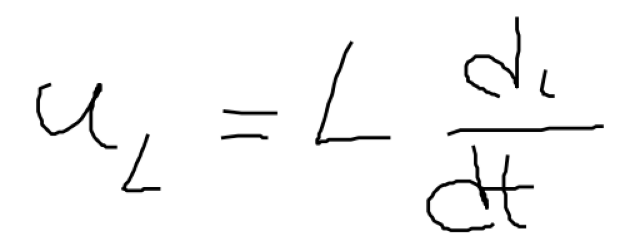

Predicted LaTeX: u u L u _i u{ u = u i


In [ ]:

ocr = HandwrittenLatexOCR(model, feature_extractor, tokenizer)

# Single image inference
image_path = "/content/drive/MyDrive/121_em_328.inkml.png"
prediction = ocr(image_path)

# Batch inference
# image_paths = ["image1.png", "image2.png", "image3.png"]
# predictions = ocr.batch_inference(image_paths)